In [1]:
# This is the analysis to determine the youngs modulus of thin film and the fitting parameter alpha for several models from nanoindentation at several depths.

# Load usual suspects:
library(plyr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr) #operations with strings
library(shiny) #nice interactive interface


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'shiny' was built under R version 3.4.4"

In [2]:
# Define path to file
setwd("C:/Users/David Framil/Results")

In [3]:
#Load list of names and filter to keep only txt files:
Filenames <- list.files()
Nanoindentation_files <- Filenames[grepl("^.+(.txt)$",Filenames)] #grab anything that finishes in ".txt"

In [4]:
#Define a load_csv function that loads all the files, including other data such as sample name, thickness, origin and voltage. These objetcs are already converted to their particular type (string, numeric, etc)
load_csv <- function(x) {
  sample <- as.list(sapply(strsplit(x, "_"), "[", 1)) # use selection operator "[" to select which element of the list is extracted
  thickness <- as.list(str_extract(sapply(strsplit(x, "_"), "[", 2), "[[:digit:]]+[^[:alpha:]]+"))
  origin <- as.list(sapply(strsplit(x, "_"), "[", 3))
  voltage <- as.list(str_extract(sapply(strsplit(x, "_"), "[", 4), "^[^V]*")) # match anything from the beginning of the string until finding a V
  out <- read.table(x, sep = "\t", skip = 2, stringsAsFactors = FALSE, header = TRUE)
  cbind(out, `Sample name`=toString(sample), `Thickness (nm)`=as.numeric(thickness), Origin=toString(origin), `Voltage (V)`=as.numeric(voltage)) # combine per x and rename columns
}

Nanoindentation <- lapply(Nanoindentation_files, load_csv) # apply the defined function to all the filenames found in the folder
Nanoindentation <- ldply(Nanoindentation) # reconvert list back to dataframe

In [5]:
#Sort out dataframe to keep sample name, reduced modulus, hardness, effective indentation depth, thickness and voltage
Nanoindentation <- Nanoindentation[,c("Sample name", "heff.nm.", "Er.GPa.", "H.GPa.", "Thickness (nm)", "Voltage (V)")]
names(Nanoindentation) <- c("Sample name", "heff (nm)", "Er", "H (GPa)", "Thickness (nm)", "Voltage (V)")

In [6]:
#Check the data
head(Nanoindentation, 10)

Sample name,heff (nm),Er,H (GPa),Thickness (nm),Voltage (V)
#71,5.078496,42.34258,3.351022,110,-60
#71,10.240673,43.98646,3.345392,110,-60
#71,15.077749,53.45412,3.567704,110,-60
#71,20.141966,55.29207,3.600231,110,-60
#71,25.090677,64.68499,3.881134,110,-60
#71,30.175756,64.73401,4.097106,110,-60
#71,35.096534,72.77380,4.066850,110,-60
#71,40.162019,76.89330,4.269149,110,-60
#71,45.366739,82.16662,4.600505,110,-60
#71,50.317339,87.35372,4.942339,110,-60


In [7]:
#Function to define the stats output of the non-linear analysis. The input is a summary.lm object
fitting_summary <- function(nls) { 
  out <- c(nls$coefficients[1],
           nls$coefficients[2],
           nls$coefficients[3],
           nls$coefficients[4])
  names(out) <- c("Ef","alpha","Ef error", "alpha error")
  return(out)}

In [8]:
#Function to round whatever number to the nearest 5 (eg, 5, 10, 15, etc)
mround <- function(x,base){ 
  base*round(x/base) 
} 

In [9]:
#Function to add the voltage as column based on the sample names that exist in the Nanoindentation variable
add_voltage <- function(x) {
  x$`Voltage (V)` <- Nanoindentation$`Voltage (V)`[match(x$`Sample name`, Nanoindentation$`Sample name`)]
  x
}

In [10]:
#Some definitions for the drop-down lists and interactive plottings
models <- c("None", "Exponential", "Inverse exponential", "Doerner-Nix", "Inverse Doerner-Nix")
model_formulas <- c("", "y ~ (Es*(1-exp(-c*x)) + b*exp(-c*x))", "y ~ (b*Es)/(b*(1-exp(-c*x)) + Es*exp(-c*x))", "y ~ (b*Es)/(Es*(1-exp(-c/x)) + b*exp(-c/x))", "y ~ (b*(1-exp(-c/x)) + Es*exp(-c/x))")
model_initial_b <- c("", rep(20,4))
model_initial_c <- c("", 2.5, 2.5, 0.1, 0.1)
options_model <- data.frame(models, model_formulas, model_initial_b, model_initial_c)
options_rep <- c("Experimental points", "Average + standard deviation")

In [11]:
#Function for plotting voltage in different tab (and getting error input if model does not exist)
no_model <- function(x) {
  if (x == "None") {
    "Please choose a fitting model to determine the Young's modulus"
  } else if (x == "") {
    FALSE
  } else {
    NULL
  }
}

In [12]:
Es <- 134.4 #Experimental Es of silicon at 300 uN x 24 indents, Berkovich

In [13]:
#Extraction of coefficients for different model fittings according to antunes et al
E_fit <- function(x, f, b_0, c_0){
  x$y <- x$Er
  x$x <- x$`heff (nm)`/x$`Thickness (nm)`
  Results <- dlply(x, .(`Sample name`), function(n) nls(as.formula(as.character(f)), data = n, start = list(b = as.numeric(as.character(b_0)), c = as.numeric(as.character(c_0))), control = list(maxiter = 100000, minFactor = 1e-10, tol = 0.05))) #Group by sample name and fit the nonlinear model, result as list
  Results <- llply(Results, summary) #apply the summary to each of the fittings per sample name. Returns a list
  wrap_up <- list() #define empty list
  for (i in 1:length(Results)) { #loop for all the sample names
    wrap_up[[names(Results)[i]]] <- fitting_summary(Results[[i]]) #build a list that maps the fitted coefficients to the sample
  }
  Results <- ldply(wrap_up, .id = "Sample name") #combine back to dataframe
  Results
}

In [14]:
#Define the shiny user interface
modulusui <- shinyUI(
  fluidPage(
    titlePanel("Reduced modulus as a function of normalized indentation depth"),
    sidebarLayout(
      sidebarPanel(selectInput("model", label = "Choose the model to fit the data:",
                               choices = options_model[1]),
                   selectInput("rep", label = "Choose the type of representation:",
                               choices = options_rep)),
      mainPanel(tabsetPanel(
        tabPanel("Mechanical properties", plotOutput("E_plot")), 
        tabPanel("Voltage dependence", plotOutput("V_plot")), 
        tabPanel("Fitting results", tableOutput("table")))
      )
    )
  )
)

In [15]:
#Define the interactive plottings
modulusserver <- shinyServer(function(input, output){
  output$E_plot <- renderPlot({ #main plot, reduced modulus VS depth
    if (input$rep == options_rep[1]) { #experimental points representation
      scatter_plot <- ggplot(Nanoindentation, aes(x=`heff (nm)`/`Thickness (nm)`, y=Er, color=`Sample name`)) + geom_point() + 
        scale_x_continuous(limits = c(0,0.5), breaks = seq(0, 0.5, 0.05)) + 
        scale_y_continuous(limits = c(0,100), breaks = seq(0, 100, 10)) + 
        xlab("h/t") + ylab("Reduced Young's modulus (GPa)") + 
        scale_color_discrete(name = "Sample") + 
        geom_hline(yintercept = 69.8, size = 1) + #theoretical value
        geom_hline(yintercept = 134.4, size = 1) #limit value
      if (input$model == options_model[1,1]) { #plot as is
        scatter_plot
      } else if (input$model != options_model[1,1]) { #plot as is + superpose a line fitted to the model selected
        scatter_plot + geom_smooth(method = "nls", se = FALSE, fullrange = TRUE, 
                                   formula = as.formula(as.character(options_model[options_model$models==input$model,2])),
                                   method.args = list(start = list(b = as.numeric(as.character(options_model[options_model$models==input$model,3])), c = as.numeric(as.character(options_model[options_model$models==input$model,4]))), control = list(maxiter = 100000, minFactor = 1e-10, tol = 0.05)))
      }
    } else if (input$rep == options_rep[2]) { #average + standard deviation representation
      mean_plot <- Nanoindentation %>%
        group_by(`Sample name`, mround(`heff (nm)`,5), `Thickness (nm)`) %>%
        summarise(meany=mean(Er), sdy=sd(Er), meanx=mean(`heff (nm)`), sdx=sd(`heff (nm)`)) #construct a mean values dataframe centered around specific intervals of 5nm
      
      mean_plot <- data.frame(mean_plot)
      names(mean_plot) <- c("Sample name", "heff (nm)", "Thickness (nm)", "meany", "sdy", "meanx", "sdx")
      
      scatter_plot <- ggplot() + geom_point(data=mean_plot, aes(x=meanx/`Thickness (nm)`, y=meany, color=`Sample name`)) + 
        geom_errorbar(data=mean_plot, aes(x=meanx/`Thickness (nm)`, ymin=meany-sdy, ymax=meany+sdy, color=`Sample name`), width=0.005) + 
        geom_errorbarh(data=mean_plot, aes(x=meanx/`Thickness (nm)`, y=meany, xmin=meanx/`Thickness (nm)`-sdx/`Thickness (nm)`, xmax=meanx/`Thickness (nm)`+sdx/`Thickness (nm)`, color=`Sample name`), height=0.05) + 
        scale_x_continuous(limits = c(0,0.5), breaks = seq(0, 0.5, 0.05)) + 
        scale_y_continuous(limits = c(0,100), breaks = seq(0, 100, 10)) + 
        xlab("h/t") + ylab("Reduced Young's modulus (GPa)") + 
        scale_color_discrete(name = "Sample") + 
        geom_hline(yintercept = 69.8, size = 1) + 
        geom_hline(yintercept = 134.4, size = 1)
      if (input$model == options_model[1,1]) {
        scatter_plot
      } else if (input$model != options_model[1,1]) {
        scatter_plot + geom_smooth(data=Nanoindentation, aes(x=`heff (nm)`/`Thickness (nm)`, y=Er, color=`Sample name`), 
                                   method = "nls", se = FALSE, fullrange = TRUE, 
                                   formula = as.formula(as.character(options_model[options_model$models==input$model,2])),
                                   method.args = list(start = list(b = as.numeric(as.character(options_model[options_model$models==input$model,3])), c = as.numeric(as.character(options_model[options_model$models==input$model,4]))), control = list(maxiter = 100000, minFactor = 1e-10, tol = 0.05)))
      }
    }
  })
  output$V_plot <- renderPlot({ #secondary plot, reduced modulus against voltage
    validate(
      need(input$model != "None", "Please choose a model to fit the data")
    )
    Results_voltage <- add_voltage(E_fit(Nanoindentation, options_model[options_model$models==input$model,2], options_model[options_model$models==input$model,3], options_model[options_model$models==input$model,4]))
    ggplot(Results_voltage, aes(y=Ef, x=`Voltage (V)`)) + geom_point() + geom_errorbar(aes(ymin=Ef-`Ef error`, ymax=Ef+`Ef error`), width=0.005) + 
      scale_x_continuous(limits = c(-120,0), breaks = seq(0, -120, -20)) + 
      scale_y_continuous(limits = c(0,50), breaks = seq(0, 50, 10)) + 
      geom_smooth(method = "nls", se = FALSE, fullrange = TRUE, formula = y ~ b*abs(x)^n+c,
                  method.args = list(start = list(n=1, b=5, c=20), control = list(maxiter = 100000, minFactor = 1e-10, tol = 0.05))) #fit to a general power law. Only interesting to have a visual depiction of the trend, not trying to reproduce any model whatsoever.
  })
  output$table <- renderTable({ #fitted parameters according to the selected fitting model
    validate(
      need(input$model != "None", "Please choose a model to fit the data")
    )
    Final_results <- add_voltage(E_fit(Nanoindentation, options_model[options_model$models==input$model,2], options_model[options_model$models==input$model,3], options_model[options_model$models==input$model,4]))
    Final_results <- Final_results[,c("Sample name", "Ef", "Ef error", "Voltage (V)")]
    names(Final_results) <- c("Sample name", "Reduced Young's modulus (GPa)", "Fitting error (GPa)", "Voltage (V)")
    Final_results
  })
})

In [16]:
#shinyApp(ui = modulusui, server = modulusserver) #uncheck to run the shiny application interface

Warning message:
"Removed 83 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 83 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_hline)."

Warning message:
"Removed 8 rows containing missing values (geom_point)."Warning message:
"Removed 8 rows containing missing values (geom_errorbar)."Warning message:
"Removed 9 rows containing missing values (geom_errorbarh)."Warning message:
"Removed 1 rows containing missing values (geom_hline)."

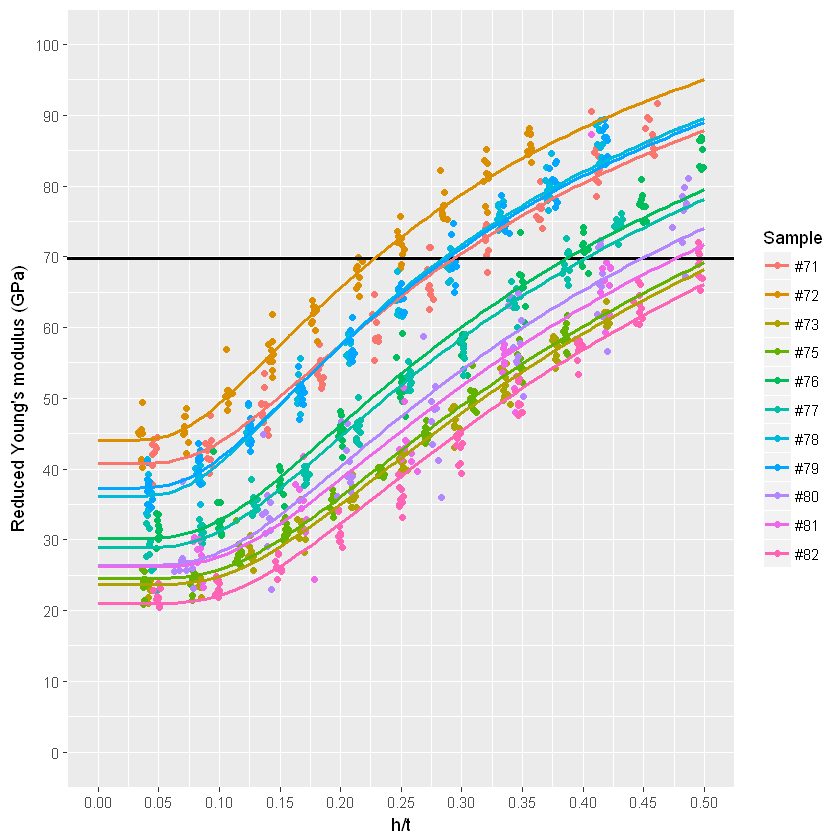

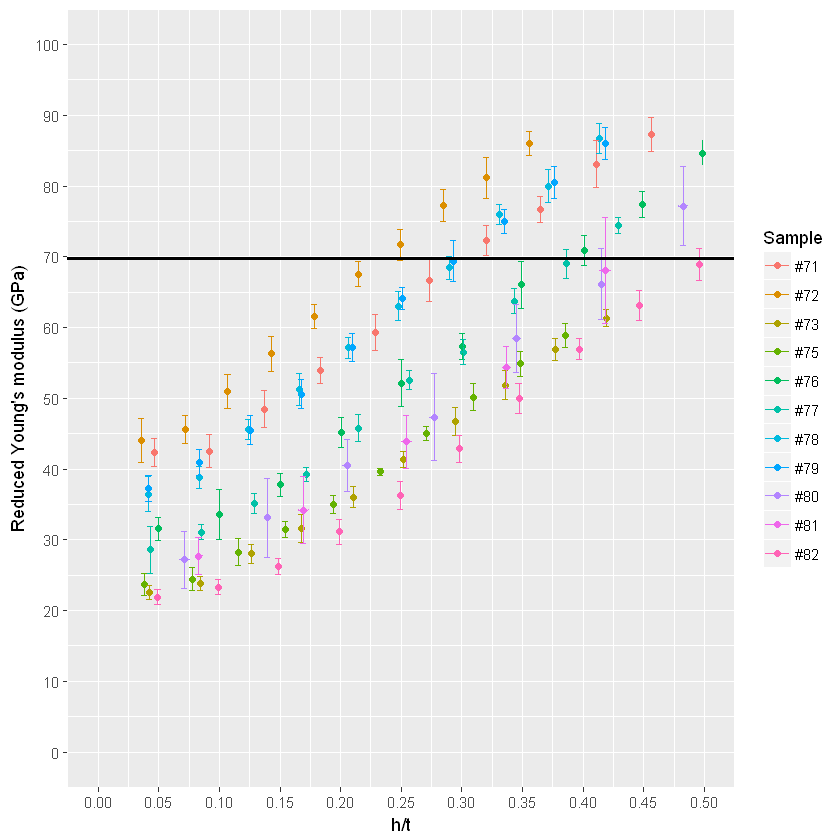

In [17]:
#Example of plots that will appear in the app

par(mfrow=c(2,1))
scatter_plot <- ggplot(Nanoindentation, aes(x=`heff (nm)`/`Thickness (nm)`, y=Er, color=`Sample name`)) + geom_point() + 
        scale_x_continuous(limits = c(0,0.5), breaks = seq(0, 0.5, 0.05)) + 
        scale_y_continuous(limits = c(0,100), breaks = seq(0, 100, 10)) + 
        xlab("h/t") + ylab("Reduced Young's modulus (GPa)") + 
        scale_color_discrete(name = "Sample") + 
        geom_hline(yintercept = 69.8, size = 1) + 
        geom_hline(yintercept = 134.4, size = 1)
scatter_plot + geom_smooth(method = "nls", se = FALSE, fullrange = TRUE, 
                                   formula = y ~ (b*(1-exp(-c/x)) + Es*exp(-c/x)),
                                   method.args = list(start = list(b = 20, c = 0.1), control = list(maxiter = 100000, minFactor = 1e-10, tol = 0.05)))

mean_plot <- Nanoindentation %>%
        group_by(`Sample name`, mround(`heff (nm)`,5), `Thickness (nm)`) %>%
        summarise(meany=mean(Er), sdy=sd(Er), meanx=mean(`heff (nm)`), sdx=sd(`heff (nm)`)) #construct a mean values dataframe centered around specific intervals of 5nm
      
      mean_plot <- data.frame(mean_plot)
      names(mean_plot) <- c("Sample name", "heff (nm)", "Thickness (nm)", "meany", "sdy", "meanx", "sdx")
      
      scatter_mean_plot <- ggplot() + geom_point(data=mean_plot, aes(x=meanx/`Thickness (nm)`, y=meany, color=`Sample name`)) + 
        geom_errorbar(data=mean_plot, aes(x=meanx/`Thickness (nm)`, ymin=meany-sdy, ymax=meany+sdy, color=`Sample name`), width=0.005) + 
        geom_errorbarh(data=mean_plot, aes(x=meanx/`Thickness (nm)`, y=meany, xmin=meanx/`Thickness (nm)`-sdx/`Thickness (nm)`, xmax=meanx/`Thickness (nm)`+sdx/`Thickness (nm)`, color=`Sample name`), height=0.05) + 
        scale_x_continuous(limits = c(0,0.5), breaks = seq(0, 0.5, 0.05)) + 
        scale_y_continuous(limits = c(0,100), breaks = seq(0, 100, 10)) + 
        xlab("h/t") + ylab("Reduced Young's modulus (GPa)") + 
        scale_color_discrete(name = "Sample") + 
        geom_hline(yintercept = 69.8, size = 1) + 
        geom_hline(yintercept = 134.4, size = 1)
scatter_mean_plot